In [2]:
import numpy as np
import torch 
from torch.utils.data import Dataset , DataLoader, ConcatDataset
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix , accuracy_score
import cv2
import random
import sys

In [3]:
tumor=[]
path='./dataset/yes/*.jpg'
for f in glob.iglob(path):
    img=cv2.imread(f)
    img=cv2.resize(img , (128 , 128))
    b, g, r=cv2.split(img)
    img=cv2.merge([r , g , b])
    tumor.append(img)
    

In [4]:
len(tumor)

704

In [5]:
# for img in tumor:
#     print(img.shape)

In [6]:
health=[]
path='./dataset/no/*.jpg'
for f in glob.iglob(path):
    img=cv2.imread(f)
    img=cv2.resize(img , (128 , 128))
    b, g, r=cv2.split(img)
    img=cv2.merge([r , g , b])
    health.append(img)

In [7]:
# Converting into numpy array 
health=np.array(health)
tumor=np.array(tumor)

In [8]:
health.shape

(2000, 128, 128, 3)

In [9]:
tumor.shape
health.shape
All=np.concatenate((health , tumor))

In [10]:
All.shape

(2704, 128, 128, 3)

# Visualizing the image 


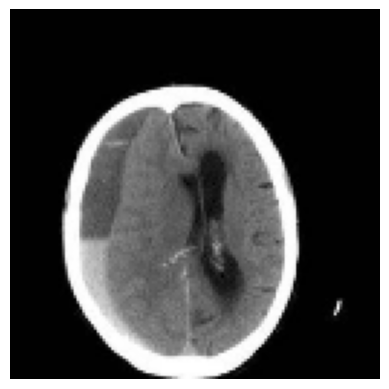

In [11]:
plt.imshow(health[0])
plt.axis('off') 
plt.show()

In [12]:
# Create a fucntion which select 5 random image from each set of nupy array 

In [13]:
def plot_random(health , tumor , num=5):
    health_images = health[np.random.choice(len(health) , num , replace=False)]
    tumor_images=tumor[np.random.choice(len(tumor) , num, replace=False)]
    plt.figure(figsize=(16 , 9))
    for i in range(num):
        plt.subplot(1 , num , i+1)
        plt.title("Health_images")
        plt.imshow(health_images[i])
        
    plt.figure(figsize=(16 , 9))
    for i in range(num):
        plt.subplot(1 , num , i+1)
        plt.title("Tumor images")
        plt.imshow(tumor[i])    
            

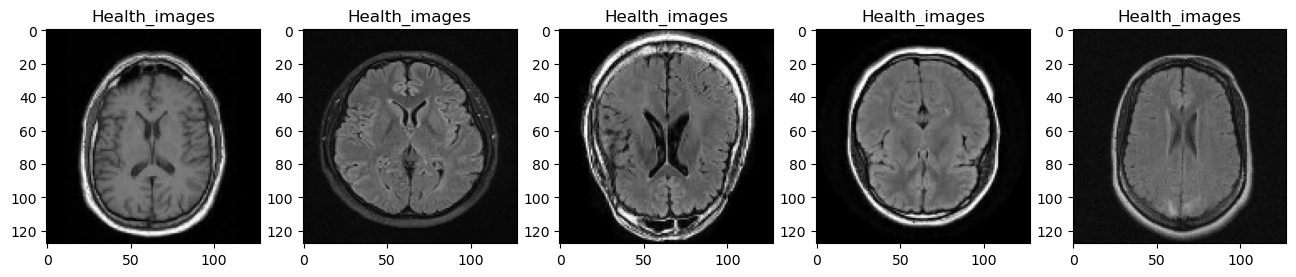

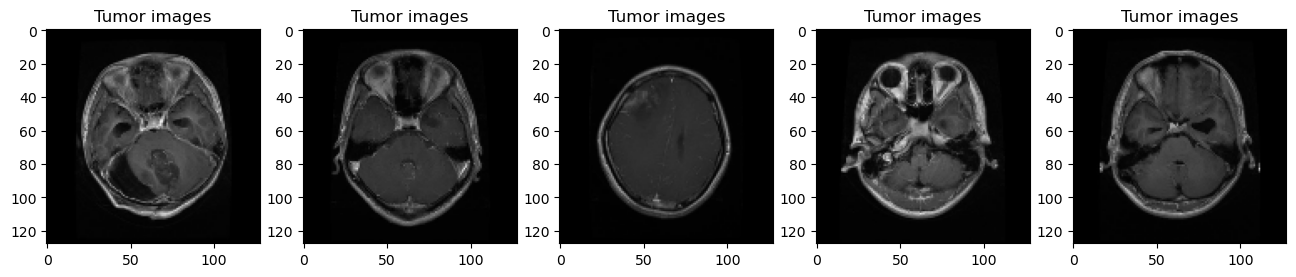

In [14]:
plot_random(health, tumor , 5)

In [15]:
class Dataset(object):
     def __getitem__(self, index):
         raise NotImplementedError
     def __len__(self):
         raise NotImplementedError
     def __add__(self , other):
         return ConcatDataset([self , other])

In [16]:
# For example to teach you
class test(Dataset):
    def __init__(self, scores):
        self.x=scores
    def __getitem__(self , index):
        return self.x[index]
    def __len__(self):
        return len(self.x)
    def __add__(self, x):
        return ConcatDataset([self ,x])

In [17]:
scores=[1,2 ,3,4,5]
d=test(scores)
d.x
scores_2=[400 , 500 , 400 , 500, 300]
d2=test(scores_2)

Creating actual class for it 

In [18]:
class MRI(Dataset):
    def __init__(self):
        tumor=[]
        path='./dataset/yes/*.jpg'
        for f in glob.iglob(path):
            img=cv2.imread(f)
            img=cv2.resize(img , (128 , 128))
            b, g, r=cv2.split(img)
            img=cv2.merge([r , g , b])
            tumor.append(img)
    
        health=[]
        path='./dataset/no/*.jpg'
        for f in glob.iglob(path):
            img=cv2.imread(f)
            img=cv2.resize(img , (128 , 128))
            b, g, r=cv2.split(img)
            img=cv2.merge([r , g , b])
            health.append(img)

        health=np.array(health)
        tumor=np.array(tumor)

        # now label images 1 with tumor 0 for with out tumor
        tumor_label=np.ones(tumor.shape[0] , dtype=np.float32)
        health_label=np.zeros(health.shape[0] ,  dtype=np.float32)
        
        self.images=np.concatenate((health , tumor) , axis=0)
        self.label=np.concatenate((tumor_label , health_label))
    def __len__(self):
        return  self.images.shape[0]
    def __getitem__(self , index):
        sample={'image':self.images[index] , 'labels':self.label[index] }
        return sample
    def normalize(self):
        self.images=self.images/255.0


In [19]:
mri=MRI()

In [20]:
mri.normalize()

In [21]:
img=mri[5]['image']

In [22]:
np.max(img)

np.float64(0.7843137254901961)

In [23]:
# index =list(range(len(mri)))
# # u can shuffle it by using random library 
# random.shuffle(index)
# # now u want to plot the image randomly 
# for idx in index:
#     sample=mri[idx]
#     img=sample['image']
#     # img=img.reshape(img.shape[2] , img.shape[1] , img.shape[0])
#     plt.imshow(img)
#     plt.show()


The world with dataloader

In [24]:
dataloader=DataLoader(mri , shuffle=True , batch_size=10)

In [25]:
for sample in dataloader:
    img=sample['image']
    img = img.permute(0, 3, 1, 2)
    print(img.shape)
    sys.exit()

torch.Size([10, 3, 128, 128])


SystemExit: 

C:\Users\za220\anaconda3\envs\BrainTumor\lib\site-packages\IPython\core\interactiveshell.py:3558: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [26]:
# Now define the model 
import torch.nn as nn 
import torch.nn.functional as F


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn_model=nn.Sequential(
            nn.Conv2d(in_channels=3 , out_channels=6 , kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2 , stride=5),
            nn.Conv2d(in_channels=6 , out_channels=16 , kernel_size=5), 
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2 , stride=5),
        )
        self.fc_model=nn.Sequential(
            nn.Linear(in_features=256 , out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120 , out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84 , out_features=1),
            nn.Tanh())

 
    def forward(self , x):
        x=self.cnn_model(x)
        # x=x.view(x.size(0) , -1)
        x = x.contiguous().view(x.size(0), -1)
        x=self.fc_model(x)
        x = torch.sigmoid(x)


        return x
        
        

In [27]:
model =CNN()


In [28]:
model

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
    (5): Tanh()
  )
)

In [29]:
model.cnn_model

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): Tanh()
  (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Tanh()
  (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
)

In [30]:
model.cnn_model[0]

Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))

In [31]:
model.cnn_model[0].weight

Parameter containing:
tensor([[[[-7.4229e-02,  2.0750e-03, -5.7383e-02,  5.4935e-02,  9.6448e-03],
          [ 3.6822e-02, -6.8474e-02,  1.0525e-01, -9.4844e-02,  8.3537e-02],
          [ 7.9371e-02, -9.5682e-02,  5.5888e-02, -1.0520e-01, -7.3045e-02],
          [-2.5071e-02, -2.8698e-02,  9.3595e-03,  9.2743e-02, -8.8630e-02],
          [ 9.7789e-02, -6.2784e-02, -1.1097e-01,  6.9398e-02,  9.5349e-02]],

         [[-7.9346e-02,  7.7958e-02, -1.2789e-02,  9.3210e-03,  3.7783e-02],
          [-1.0084e-01, -2.7777e-02, -7.2398e-02, -6.2568e-02,  5.1323e-02],
          [-1.0570e-01, -4.8120e-03,  9.5758e-02, -6.2058e-02, -2.9130e-02],
          [ 2.7310e-02,  1.0708e-01, -6.4982e-02,  9.7373e-02,  3.4208e-02],
          [-9.3108e-02,  9.7328e-02, -2.3810e-02,  3.3980e-02,  4.8335e-02]],

         [[ 3.2301e-02,  3.0797e-02,  8.3963e-02, -6.2538e-02, -9.8132e-03],
          [-5.9731e-02, -1.1290e-01,  3.8989e-02, -1.1745e-02,  9.5047e-02],
          [-6.3009e-02, -9.1684e-02,  8.8822e-02, 

In [32]:
# Learn one thing kernel_size is 5 x 5 grid which moves over the images and extract texture , pattern , edges , horizontal , veritical recognition
# out_comes what is out_come this the third dimension of the image which we keep on increasing on layer by layer why we are increasing i will tell on detail 
#Dont worry about it 

In [33]:
# I do not know why both are on cpu right know i trying to convert all of my data and model on the same gpu other wise they cannot communicate
# with each other 
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cpu_tensor=torch.rand(10)
gpu_tensor=cpu_tensor.to(device)

print(cpu_tensor ,  cpu_tensor.type())
print(gpu_tensor , gpu_tensor.type())

tensor([0.4885, 0.2040, 0.2581, 0.0285, 0.6149, 0.3327, 0.8282, 0.8482, 0.7787,
        0.3883]) torch.FloatTensor
tensor([0.4885, 0.2040, 0.2581, 0.0285, 0.6149, 0.3327, 0.8282, 0.8482, 0.7787,
        0.3883], device='cuda:0') torch.cuda.FloatTensor


In [34]:
# Tensor multiply with each other when they are of same type other wise they dont multiply
print(cpu_tensor * gpu_tensor)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

### Evaluate dumb model neural network 

In [ ]:
# How can we achieve this hold on come with me 

In [35]:
mri_dataset=MRI()

In [36]:
mri_dataset.normalize()

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)



In [38]:
dataloader=DataLoader(mri_dataset , batch_size=32 , shuffle=False)

In [41]:
model.eval()
output=[]
y_true=[]
with torch.no_grad():
    for D in dataloader:
        
        image=D['image'].to(device).float()
        image = image.permute(0, 3, 1, 2).contiguous()

        # image= image.reshape(image.shape[0] , image.shape[1], image.shape[2])
        label=D['labels'].to(device).float()
        y_hat=model(image)
        output.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())  
    


In [55]:
output=np.concatenate(output , axis=0).squeeze() # convert it into single array prev its shape was 2704 , 1 we convert into 2704 ,0
y_true=np.concatenate(y_true , axis=0).squeeze()

In [85]:
if np.array_equal(y_true, mri_dataset.label):
    print("True")



True


In [56]:
output[0:5]

array([0.5150369 , 0.51647556, 0.5148541 , 0.5164836 , 0.5137663 ],
      dtype=float32)

In [57]:
output.shape 

(2704,)

In [63]:
def threshold(scores ,threshold=0.5 , minimum=0 , maximum=1):
    x=np.array(list(scores))
    x[x>threshold]=maximum
    x[x<threshold]=minimum
    return x

In [68]:
v=threshold(output)
v[0:120]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.], dtype=float32)

In [69]:
# lets check its accuracy 


In [74]:
print(type(mri_dataset.label))

<class 'numpy.ndarray'>


In [76]:
accuracy_score(y_true ,v)

0.2603550295857988

In [86]:
# as u can see dumb model accuracy is arounf 20 percent fuck fuck very beautifully fucked up 